In [196]:
import os
import re
from pathlib import Path
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [197]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [198]:
def is_gzip_file(filepath):
    with open(filepath, 'rb') as f:
        return f.read(2) == b'\x1f\x8b'
def display_all(df):
    plot_cols = df.columns
    plot_features = df[plot_cols]
    plot_features.index = df.index
    _ = plot_features.plot(subplots=True)

    plot_features = df[plot_cols][:960]
    plot_features.index = df.index[:960]
    _ = plot_features.plot(subplots=True)

In [199]:
csv_path = tf.keras.utils.get_file(
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/era5-land_timeseries_filled.csv.zip')
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/sis_selected_timeseries.csv.tar.gz')
    origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/utci_selected_timeseries.csv.tar.gz')
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/era5-hourly_timeseries.csv.tar.gz')
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/era5-land_timeseries.csv.tar.gz')
csv_path

'/Users/watcharinsarachai/.keras/datasets/utci_selected_timeseries.csv.tar.gz'

In [200]:
date_col = 'datetime' 
if is_gzip_file(csv_path):
  # Read the data directly into a pandas DataFrame
  df = pd.read_csv(csv_path, compression='gzip')
else:
  # Read the data without compression
  df = pd.read_csv(csv_path)
df = df.rename(columns={df.columns[0]: date_col})

# Ensure timestamp column is datetime type
if df[date_col].dtype != 'datetime64[ns]':
    df[date_col] = pd.to_datetime(df[date_col])
    
row_count = df.shape[0]
print(f"Total rows: {row_count}")
df.head(5)

Total rows: 57697


,datetime,utci_mean
0,2019-01-01 00:00:00,291.970684
1,2019-01-01 01:00:00,294.052976
2,2019-01-01 02:00:00,296.218970
3,2019-01-01 03:00:00,298.282307
4,2019-01-01 04:00:00,301.553607


In [201]:
if 'lowAccSis' in df.columns:
    df.pop('lowAccSis')
df.head(5)

,datetime,utci_mean
0,2019-01-01 00:00:00,291.970684
1,2019-01-01 01:00:00,294.052976
2,2019-01-01 02:00:00,296.218970
3,2019-01-01 03:00:00,298.282307
4,2019-01-01 04:00:00,301.553607


In [202]:
print(df[date_col].dt.year.unique())
print(df[date_col].dt.year.value_counts())

[2019. 2020. 2021. 2022. 2023. 2024. 2025.   nan]
datetime
2020.0    8784
2024.0    8784
2019.0    8760
2021.0    8760
2022.0    8760
2023.0    8760
2025.0    5088
Name: count, dtype: int64


In [203]:
df.shape

(57697, 2)

In [204]:
# Sort by time if it exists
df.index = df[date_col]
df.pop(date_col)
df = df.sort_index()
print(df.shape)
df.head(5)

(57697, 1)


,utci_mean
datetime,
2019-01-01 00:00:00,291.970684
2019-01-01 01:00:00,294.052976
2019-01-01 02:00:00,296.218970
2019-01-01 03:00:00,298.282307
2019-01-01 04:00:00,301.553607


In [205]:
print(df.index.year.unique())
print(df.index.year.value_counts())

Index([2019.0, 2020.0, 2021.0, 2022.0, 2023.0, 2024.0, 2025.0, nan], dtype='float64', name='datetime')
datetime
2020.0    8784
2024.0    8784
2019.0    8760
2021.0    8760
2022.0    8760
2023.0    8760
2025.0    5088
Name: count, dtype: int64


In [206]:
print(df.index.min())
print(df.index.max())

2019-01-01 00:00:00
2025-07-31 23:00:00


In [207]:
# Try inference first
interval_time = pd.infer_freq(df.index)
print(interval_time)

if interval_time is None:
    delta = df.index.to_series().diff().dropna()
    d = delta.mode().iloc[0] if not delta.mode().empty else delta.median()
    if d % pd.Timedelta(days=1) == pd.Timedelta(0):
        interval_time = 'D'
    elif d % pd.Timedelta(hours=1) == pd.Timedelta(0):
        interval_time = f"{int(d / pd.Timedelta(hours=1))}h"
    elif d % pd.Timedelta(minutes=1) == pd.Timedelta(0):
        interval_time = f"{int(d / pd.Timedelta(minutes=1))}min"
    else:
        interval_time = f"{int(d.total_seconds())}s"
print(interval_time)

start_date = df.index.min().floor(interval_time)
end_date = df.index.max().floor(interval_time)
complete_index = pd.date_range(start=start_date, end=end_date, freq=interval_time)
print(complete_index.shape)
print(complete_index.min())
print(complete_index.max())

None
1h
(57696,)
2019-01-01 00:00:00
2025-07-31 23:00:00


In [208]:
# Create a DataFrame with the complete index
df_complete = pd.DataFrame(index=complete_index)
# Join with original data
df_with_all_times = df_complete.join(df)

print(df.shape)
print(df_with_all_times.shape)

df_with_all_times.head(5)

(57697, 1)
(57696, 1)


,utci_mean
2019-01-01 00:00:00,291.970684
2019-01-01 01:00:00,294.052976
2019-01-01 02:00:00,296.218970
2019-01-01 03:00:00,298.282307
2019-01-01 04:00:00,301.553607


In [209]:
# Print missing data statistics
missing_count = df_with_all_times.isna().any(axis=1).sum()
print(f"Found {missing_count} missing timestamps out of {len(complete_index)} expected")

Found 0 missing timestamps out of 57696 expected


In [210]:
# Fill missing values using multiple methods
df_filled = df_with_all_times.copy()

# Interpolate small gaps (up to 1 hour = 4 timestamps)
df_filled = df_filled.interpolate(method='time', limit=4)

In [211]:
# Print missing data statistics
missing_count = df_filled.isna().any(axis=1).sum()
print(f"Found {missing_count} missing timestamps out of {len(complete_index)} expected")

Found 0 missing timestamps out of 57696 expected


In [212]:
plot_cols = list(df.columns)
plot_cols

['utci_mean']

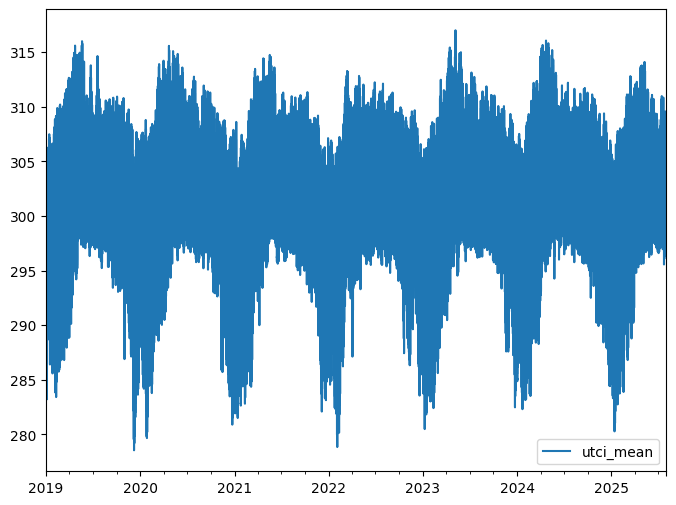

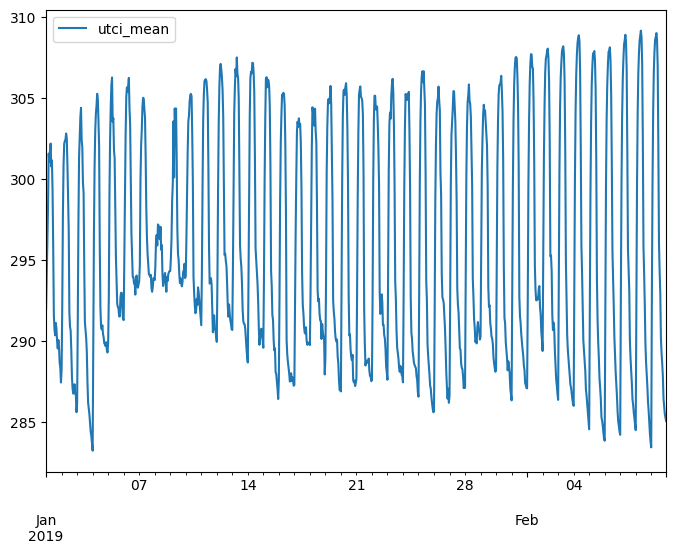

In [213]:
plot_features = df_filled[plot_cols]
plot_features.index = df_filled.index
_ = plot_features.plot(subplots=True)

plot_features = df_filled[plot_cols][:960]
plot_features.index = complete_index[:960]
_ = plot_features.plot(subplots=True)

In [214]:
nan_rows = df_filled[df_filled.isna().any(axis=1)]
nan_rows

,utci_mean


In [215]:
# Replace all NaN values in the DataFrame with 0
df_filled = df_filled.fillna(0)

In [216]:
# Count NaNs in each column
print(df_filled.isna().sum())

utci_mean    0
dtype: int64


In [217]:
df_filled.min()

utci_mean    278.554715
dtype: float64

In [218]:
df_filled.max()

utci_mean    317.007885
dtype: float64

In [219]:
len(df_filled)

57696

In [220]:
filename = Path(csv_path).name
base = re.split(r'\.', filename, 1)[0]
print(base)

utci_selected_timeseries


In [221]:
# Compressed CSV
df_filled.to_csv(base + '_filled.csv')